In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

import tensorflow as tf

from tensorflow import keras
from keras import (
    backend as K,
    losses,
    optimizers,
    layers,
    models,
    utils,
    callbacks
)

from pathlib import Path
import time

## Load Data 🩻

In [26]:
data_dir = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification"

# load the train data

train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)
[]
#load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 9032 files belonging to 10 classes.
Using 8129 files for training.
Found 9032 files belonging to 10 classes.
Using 903 files for validation.


## Prepresses Data 🔧

In [27]:
# Inspect class names

class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [28]:
# data preprocessing

def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [29]:
# get train data and labels

x_train = []
y_train = []

for images, labels in train_dataset:
    #append train data to x_train
    x_train.append(images.numpy())

    #append labels to y_train
    y_train.append(labels.numpy())

# concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [30]:
# get val data and labels

x_val = []
y_val = []

for images, labels in val_dataset:
    #append train data to x_train
    x_val.append(images.numpy())

    #append labels to y_train
    y_val.append(labels.numpy())

# concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [31]:
# one-hot encode the train, val data

NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

## Initialize Model 🤌



In [32]:

def initialize_model(x_train):

    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding="same", input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(64, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(128, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(256, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=100))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Dense(units=10, activation="softmax"))

    opt = optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    model.summary()

    return model

model = initialize_model(x_train)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 dropout_10 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                     

## Train the Model 💪 

In [33]:
# save checkpoints to monitor best performing models

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [60]:
# train the model

start_train_time = datetime.now()

history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)
end_train_time = datetime.now()
train_time = (end_train_time - start_train_time).total_seconds()

Epoch 1/10
  1/255 [..............................] - ETA: 3:53 - loss: 0.2374 - accuracy: 0.9375

KeyboardInterrupt: 

## Evaluate the Model 🕵️‍♂️

In [35]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

In [65]:
# evaluate the mode and time the eva

# start timer
start_eval_time = datetime.now()

model.evaluate(x_val, y_val)

# end timer
end_eval_time = datetime.now()
eval_time = (end_eval_time - start_eval_time).total_seconds()

29/29 [==============================] - 2s 77ms/step - loss: 0.1920 - accuracy: 0.9635


## Plote Learning Curve 📊

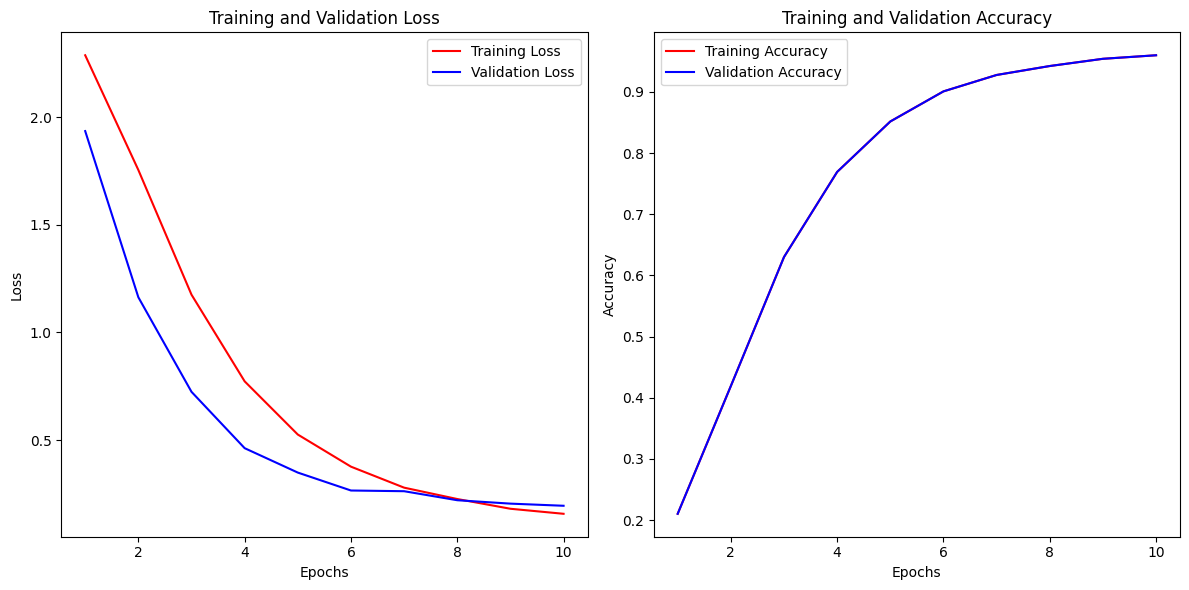

In [37]:
# plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Calculate Preformance 🔍

In [96]:
# get predictions of the model and time the predictions


# start prediction timer
start_pred_time = datetime.now()

preds = model.predict(x_val)

CLASSES = np.array(class_names)

predictions = CLASSES[np.argmax(preds, axis=-1)]
y_val_classes = CLASSES[np.argmax(y_val, axis=-1)]

# Ender prediction timer
end_pred_time = datetime.now()
pred_time = (end_pred_time - start_pred_time).total_seconds()

29/29 [==============================] - 3s 82ms/step


In [41]:
# After evaluating the model and generating predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_val_classes and predictions are defined as per your script
accuracy = accuracy_score(predictions, y_val_classes)
precision = precision_score(predictions, y_val_classes, average='weighted')
recall = recall_score(predictions, y_val_classes, average='weighted')
f1 = f1_score(predictions, y_val_classes, average='weighted')

# Save the metrics to a file
with open("metrics.txt", "w") as file:
    file.write(f"{accuracy}\n")
    file.write(f"{precision}\n")
    file.write(f"{recall}\n")
    file.write(f"{f1}\n")

# Optionally, print the metrics for quick reference
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9623477297895903
Precision: 0.9628529870551902
Recall: 0.9623477297895903
F1 Score: 0.9623125949373708


## Save Preformance to CSV 📝

In [52]:
import os
import pandas as pd
import time
import getpass

def log_model_metrics(metrics_file, csv_file, model_name, train_time, eval_time, pred_one_time):

    # Load metrics generated by train_eval.py
    metrics_df = pd.read_csv(metrics_file, header=None, names=["value"])
    accuracy = float(metrics_df.iloc[0].value)
    precision = float(metrics_df.iloc[1].value)
    recall = float(metrics_df.iloc[2].value)
    f1 = float(metrics_df.iloc[3].value)

    # Log results to DataFrame
    columns = ["name", "model", "train_time", "test_time", "pred_one_time", "accuracy", "precision", "recall", "f1"]
    name = getpass.getuser()  # Get the username of the person running the script

    # Create a DataFrame to hold the new data
    data = {
        "name": [name],
        "model": [model_name],
        "train_time": [train_time],
        "eval_time": [eval_time],
        "pred_one_time": [pred_one_time],
        "accuracy": [accuracy],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1]
    }
    df_new = pd.DataFrame(data)

    # Check if the file exists
    if os.path.exists(csv_file):
        # If the file exists, append the new data
        df_existing = pd.read_csv(csv_file)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        # If the file does not exist, the new data is the combined data
        df_combined = df_new

    # Save the combined data to the CSV file
    df_combined.to_csv(csv_file, index=False)


In [53]:
class_names_dict = {
    0: 'Avulsion fracture',
    1: 'Comminuted fracture',
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

In [64]:
from tensorflow.keras.preprocessing import image

def preprocess_single_image(img_path, target_size=(256, 256)):
    """
    Load and preprocess a single image
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image to [0, 1]
    return img_array

def predict_single_image(model, img_array, class_names_dict):
    """
    Make a prediction on a single image
    """
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=-1)
    class_name = class_names_dict[predicted_class[0]]
    return class_name

# Example usage
img_path = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification/Avulsion fracture/Train/94f6a-pclavulsion1a_png.rf.621b9fb0ecda5666f169e06b88d35b9e.jpg"

img_array = preprocess_single_image(img_path)

# Make prediction
start_pred_one_time = datetime.now()

predicted_class_name = predict_single_image(model, img_array, class_names_dict)

print("Predicted class:", predicted_class_name)

end_pred_one_time = datetime.now()
pred_one_time = (end_pred_one_time - start_pred_one_time).total_seconds()

1/1 [==============================] - 0s 33ms/step
Predicted class: Avulsion fracture


In [55]:
log_model_metrics("metrics.txt", "results.csv", "Original-CNN-Kaggle", train_time, eval_time, pred_one_time)

In [57]:
res = pd.read_csv('/Users/owenclary/code/Owencclary/x_ray_lewagon2024/notebooks/results.csv')

res

,name,model,train_time,eval_time,pred_one_time,accuracy,precision,recall,f1
0,owenclary,Original-CNN-Kaggle,3.437218,2.440408,0.054354,0.962348,0.962853,0.962348,0.962313
